# Notes on basic stochastic optimization.

Let's say I have a data set that looks like this, but have no idea how the data was generated.

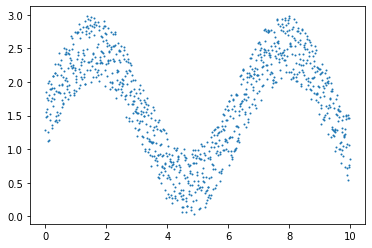

In [1]:
import math
from random import random
import matplotlib.pyplot as plt
x = [i/100 for i in range(1000)]
data = [1 + math.sin(i/100.0)+random() for i in range(1000)]
plt.scatter(x, data, s=1, label="data")
plt.show()

I chose the naive appraoch, I assume that the function looks like a `sine` with noise.

By removing the noise, the approximation function becomes clear:

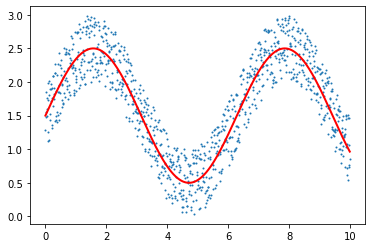

In [2]:
model = [1+math.sin(i/100.0)+0.5 for i in range(1000)]

plt.scatter(x,data,s=1,label='data')
plt.plot(x, model, linewidth=2, label="model", color='r')
plt.show()

likewise the noise can be modeled in isolation as difference between the data and the model.

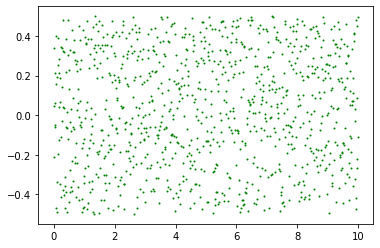

In [3]:
noise = [a-b for a,b in zip(data,model)]

plt.scatter(x, noise, s=1, color='green')
plt.show()

With this, the noise can be analyzed for additional patterns:

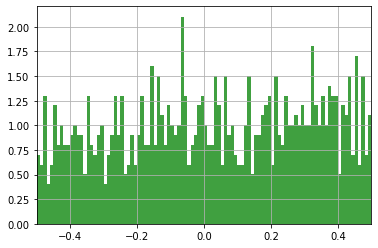

with noise ranging from -0.49930805266629874, 0.49961164092076515


In [4]:
n,bins,patches = plt.hist(noise, 100, density=True, facecolor='g', alpha=0.75)
plt.xlim(min(noise),max(noise))
plt.grid(True)
plt.show()
print(f"with noise ranging from {min(noise)}, {max(noise)}")

As there are no patterns in the "noise" and the histogram doesn't reveal any underlying pattern (skewness) it is fair to assume that the noise is uniformly random variations.

There are therefore no additional trends to be accounted for and the model is considered "suitable".

We can now calculate where the model reaches a maximum.

In [5]:
import sympy as sym
from sympy.abc import x as X
f = sym.sin(X)
sym.maximum(f,X)

1

So, the maximum of the sine model is 1, which it reaches at:

In [6]:
math.asin(1)

1.5707963267948966

The value in the model is:

In [7]:
index = model.index(max(model))
print(f"x, y = {x[index]}, {max(model)}")

x, y = 1.57, 2.4999996829318345


I may thereby define the "zone of optimality" as:

In [8]:
lower_bound = [max(model)-min(noise) for _ in x]
uppler_bound = [max(model)-max(noise) for _ in x]

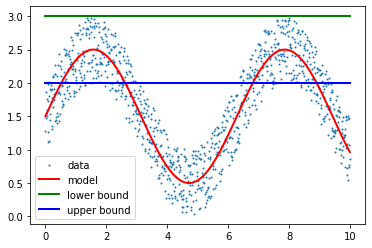

In [9]:
plt.scatter(x,data,s=1,label='data')
plt.plot(x, model, linewidth=2, label="model", color='r')
plt.plot(x, lower_bound, linewidth=2, label="lower bound", color='g')
plt.plot(x, uppler_bound, linewidth=2, label="upper bound", color='b')
plt.legend()
plt.show()

You may wonder: "If I didn't know that the model was a sine model, how would I get to that?"

Fast Fourier Transformation is one option, but requires evenly sampled data.


In [10]:
import numpy
import scipy.optimize

In [11]:

tt = numpy.array(x)
yy = numpy.array(data)
ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
Fyy = abs(numpy.fft.fft(yy))
guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
guess_amp = numpy.std(yy) * 2.**0.5
guess_offset = numpy.mean(yy)
guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

def sinfunc(t, A, w, p, c):  
    return A * numpy.sin(w*t + p) + c

popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
A, w, p, c = popt
f = w/(2.*numpy.pi)
fitfunc = lambda t: A * numpy.sin(w*t + p) + c
result = {
    "amp": A, "omega": w, "phase": p, "offset": c, "freq": f, 
    "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), 
    "rawres": (guess,popt,pcov)
}
print(result)

{'amp': 1.0000997442197253, 'omega': 1.0021066887371652, 'phase': -0.018017598256805677, 'offset': 1.52792880040001, 'freq': 0.15949023301797122, 'period': 6.26997641847649, 'fitfunc': <function <lambda> at 0x000002DA137E01F0>, 'maxcov': 0.0006154088475131316, 'rawres': (array([1.02304123, 1.25663706, 0.        , 1.71154827]), array([ 1.00009974,  1.00210669, -0.0180176 ,  1.5279288 ]), array([[ 1.84465122e-04,  3.22424790e-06, -2.51307806e-05,
        -3.28353432e-05],
       [ 3.22424790e-06,  1.73171732e-05, -8.91908719e-05,
         7.32728176e-06],
       [-2.51307806e-05, -8.91908719e-05,  6.15408848e-04,
        -2.80857542e-05],
       [-3.28353432e-05,  7.32728176e-06, -2.80857542e-05,
         9.10166157e-05]]))}


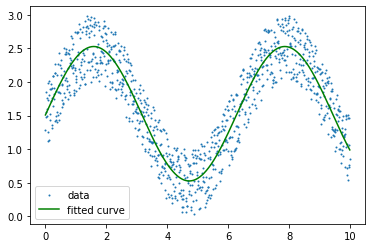

In [12]:
plt.scatter(tt,data, label='data', s=1)
plt.plot(tt, result["fitfunc"](tt), label='fitted curve', color='green')
plt.legend()
plt.show()